# Finding the best "hygge" path
This notebook explores the different ways of finding the shortest path while ensuring that the path is "hyggelig"

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import osmnx as ox
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from collections import Counter
from random import choice

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Load base street paths

In [2]:
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

# convert graph to geodataframe
nodes, edges = ox.graph_to_gdfs(G)

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


## Load bird path features
This code is an excerpt from `birds.ipynb`

In [3]:
birds = pd.read_csv('../data/birds.csv')
birds = birds.drop(columns='Unnamed: 0')

gdf = gpd.GeoDataFrame(
    birds, geometry=gpd.points_from_xy(birds.obs_laengdegrad, birds.obs_breddegrad), crs="EPSG:4326"
)

# project to EPSG:25832
gdf = gdf.to_crs('EPSG:25832')

In [4]:
# remove observations outside of Copenhagen

# load shape of Copenhagen
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
cph = ox.geocode_to_gdf(geocodes)
cph = cph.to_crs('EPSG:25832')
cph_poly = cph.dissolve().geometry.iloc[0]

# find intersecting bird observations
gdf['intersection_geometry'] = gdf.geometry.intersection(cph_poly)

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [5]:
# remove observations without exact coordinates
gdf = gdf[~gdf.intersection_geometry.is_empty]

In [6]:
# create a buffer around each observation
buffer_radius = 50  # radius (in meters due to EPSG:25832)
gdf['buffer'] = gdf.buffer(buffer_radius)
gdf_buffer = gdf.set_geometry('buffer')

In [7]:
intersections = edges.sjoin(gdf_buffer)
intersections = gpd.GeoDataFrame(intersections, geometry=intersections.geometry_left, crs=gdf.crs)

In [8]:
bird_counts = intersections.groupby(['u', 'v', 'key']).size()
bird_counts.name = 'bird_counts'

In [9]:
edges = edges.merge(bird_counts, left_index=True, right_index=True, how='left')

In [10]:
edges['bird_counts'] = edges.bird_counts.fillna(0)
edges['birds_per_m'] = edges['bird_counts'] / edges['length']

## Find best path minimizing distance and maximizing birds
Now that we have birds as edge features, we can start routing. One approach to do create a routing algorithm that maximizes "hygge" is to weight each feature, and find the shortest path on this new composite feature. We use minmax scaling to get our features down into a comparable range
$$
x_{scaled} = \frac{x-x_{min}}{x_{max}-x_{min}}
$$
For the birds, we use $1-x_{scaled}$ as the feature, such that we can minimize the feature to maximize bird sightings

In [11]:
edges['birds_scaled'] = 1 - ((edges['bird_counts'] - edges['bird_counts'].min()) / (edges['bird_counts'].max() - edges['bird_counts'].min()))
edges['birds_per_m_scaled'] = 1 - (edges['birds_per_m'] - edges['birds_per_m'].min()) / (edges['birds_per_m'].max() - edges['birds_per_m'].min())
edges['length_scaled'] = (edges['length'] - edges['length'].min()) / (edges['length'].max() - edges['length'].min())

We can now create a "hygge" score as a weighted sum of the relevant features. The specific weights are parameters that need to be tuned for optimal routing.

In [12]:
edges['w'] = 0.9 * edges['length_scaled'] + 0.1 * edges['birds_scaled']

We create a graph with the new hygge score on each edge.

In [13]:
G = ox.graph_from_gdfs(nodes, edges)

This new hygge score is designed to be minimized. By using traditional shortest path algorithms, we can find the path that minimizes the hygge score, which in turn leads to minimizing path length and maximizing bird sightings.

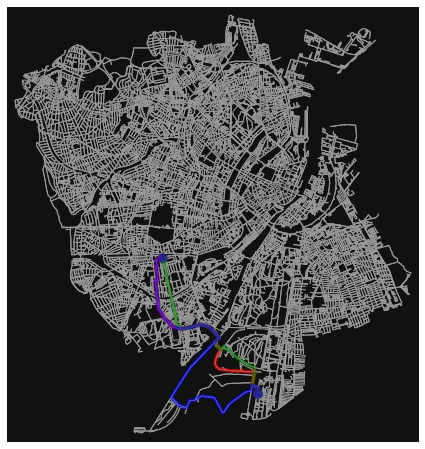

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [14]:
#orig = 118738
#dest = 1578270263

orig = choice(list(G.nodes))
dest = choice(list(G.nodes))

route_w = ox.shortest_path(G, orig, dest, weight='w')
route_l = ox.shortest_path(G, orig, dest, weight='length')
route_b = ox.shortest_path(G, orig, dest, weight='birds_scaled')
routes = [route_w, route_l, route_b]
route_labels = ['w path', 'length path', 'bird path']
ox.plot_graph_routes(G, routes, node_alpha=0, route_colors=['red', 'green', 'blue'])

In [15]:
for route, label in zip(routes, route_labels):
    print(label)
    print('length:', nx.path_weight(G, route, weight='length'))
    print('birds :', nx.path_weight(G, route, weight='bird_counts'))
    print('w     :', nx.path_weight(G, route, weight='w'))
    print()


w path
length: 7722.054000000001
birds : 93.0
w     : 8.663979851052561

length path
length: 6878.997
birds : 115.0
w     : 10.409330682402846

bird path
length: 10933.738000000003
birds : 136.0
w     : 9.685185068867632



We can use the new score for calculating betweenness as well. This will highlight all the prioritised paths in shortest path routing.

In [16]:
hygge_bn = nx.edge_betweenness_centrality(G, weight='w', k=100)
nx.set_edge_attributes(G, hygge_bn, "hygge_bn")

## Dump data

In [17]:
_, edges = ox.graph_to_gdfs(G)

In [18]:
with open('../data/edges_birds.json', 'w') as f:
    f.write(edges.to_json(show_bbox=True))